In [1]:
regression = 0
i_m_g = 1
channels = 1
cycle = 0
fft_ = 1
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import gc

import warnings 
warnings.filterwarnings('ignore')
from IPython.display import display, clear_output, FileLinks


/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/input/flicker-dataset/bb_qp38_qp26_5.yuv
/kaggle/input/flicker-dataset/bb.yuv
/kaggle/input/flicker-dataset/mr_qp44_qp26_3.yuv
/kaggle/input/flicker-dataset/bb_qp38_qp26_2.yuv
/kaggle/input/flicker-dataset/mr_qp38_qp26_5.yuv
/kaggle/input/flicker-dataset/bb_qp44_qp26_3.yuv
/kaggle/input/flicker-dataset/mr_qp32_qp26_3.yuv
/kaggle/input/flicker-dataset/bb_qp26.yuv
/kaggle/input/flicker-dataset/tr_qp38_qp26_3.yuv
/kaggle/input/flicker-dataset/tr_qp44_qp26_3.yuv
/kaggle/input/flicker-dataset/tr.yuv
/kaggle/input/flicker-dataset/tr_qp38_qp26_5.yuv
/kaggle/input/flicker-dataset/mr_qp38_qp26_2.yuv
/kaggle/input/flicker-dataset/tr_qp38_qp26_2.yuv
/kaggle/input/flicker-dataset/bb_qp32_qp26_3.yuv
/kaggle/input/flicker-dataset/phase1.mat
/kaggle/input/flicker-dataset/mr_qp38_qp26_3.yuv
/kaggle/working/__notebook__.ipynb


In [2]:
# a = np.array([1, 2, 3])
# from tempfile import TemporaryFile
# outfile = TemporaryFile()
# np.save("outfile", a)

In [3]:
# vid_tr = '/kaggle/input/flicker-dataset/tr.yuv'
vid = '/kaggle/input/flicker-dataset/tr_qp44_qp26_3.yuv'

%mkdir Y_train
%mkdir Y_test
%mkdir Y
!ls

Y  Y_test  Y_train  __notebook__.ipynb


In [4]:
import scipy.io
mat = scipy.io.loadmat('/kaggle/input/flicker-dataset/phase1.mat')

speed_per_frame = mat['phase1_object_speed'][:, -1] * 10
flicker_visibility = mat['phase1_task1_flicker_visibility'][:, 34] * 10

In [5]:
# for i,x in enumerate(mat['phase1_video_list'][0]):
#     print(i, x)

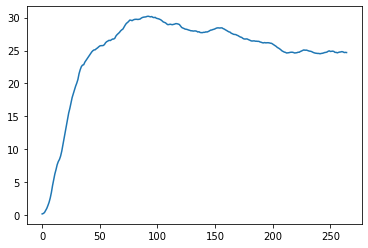

In [6]:
# plt.plot(mat['phase1_task1_flicker_visibility'][:, 7])
plt.plot(mat['phase1_task1_flicker_visibility'][:, 34])

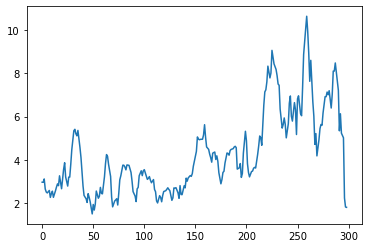

In [7]:
# plt.plot(mat['phase1_object_speed'][:, 1])
plt.plot(mat['phase1_object_speed'][:, -1])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
#os.listdir('/kaggle/input/flicker-dataset')

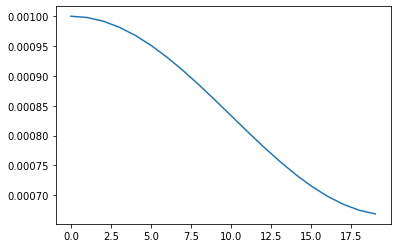

In [10]:
lx = []
lr = 0.001
r = 20
f = 1/5
x = lr/(f+1)
for epoch in tqdm_notebook(range(r)):
    lx.append(lr/(f+1) + lr/(f+1)*f*np.cos(epoch/r*np.pi))
plt.plot(lx)


In [11]:

# vid_paths = os.listdir('/kaggle/input/flicker-dataset')
# vid_paths.remove('tr.yuv')
# vid_paths.remove('phase1.mat')
# # vid_paths.remove('tr_qp26.yuv')
# vid_paths.remove('bb_qp26.yuv')
# vid_paths.remove('bb.yuv')
# # vid_paths.remove('tr_qp32_qp26_3.yuv')
# vid_paths

In [12]:

vid_paths = os.listdir('/kaggle/input/flicker-dataset/')
vid_paths.remove('tr.yuv')
vid_paths.remove('phase1.mat')
# vid_paths.remove('tr_qp26.yuv')
vid_paths.remove('bb_qp26.yuv')
vid_paths.remove('bb.yuv')
# vid_paths.remove('tr_qp32_qp26_3.yuv')
vid_paths


['bb_qp38_qp26_5.yuv',
 'mr_qp44_qp26_3.yuv',
 'bb_qp38_qp26_2.yuv',
 'mr_qp38_qp26_5.yuv',
 'bb_qp44_qp26_3.yuv',
 'mr_qp32_qp26_3.yuv',
 'tr_qp38_qp26_3.yuv',
 'tr_qp44_qp26_3.yuv',
 'tr_qp38_qp26_5.yuv',
 'mr_qp38_qp26_2.yuv',
 'tr_qp38_qp26_2.yuv',
 'bb_qp32_qp26_3.yuv',
 'mr_qp38_qp26_3.yuv']

In [13]:
vid_paths = ['tr_qp38_qp26_3.yuv',
 'tr_qp44_qp26_3.yuv',
 'tr_qp38_qp26_5.yuv',
 'tr_qp38_qp26_2.yuv',
            ]

vid_paths

['tr_qp38_qp26_3.yuv',
 'tr_qp44_qp26_3.yuv',
 'tr_qp38_qp26_5.yuv',
 'tr_qp38_qp26_2.yuv']

In [14]:
# vid_paths = ['bb_qp38_qp26_5.yuv',
#  'mr_qp44_qp26_3.yuv',
#  'tr_qp38_qp26_3.yuv',
#             ]

# vid_paths

In [15]:
def fft(img):
    if len(img.shape) == 3:
        img = img[:, :, 0]
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))

#     plt.figure(figsize=(5,5))
#     plt.subplot(121),plt.imshow(img, cmap = 'gray')
#     plt.title('Input Image'), plt.xticks([]), plt.yticks([])
#     plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
#     plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
#     plt.show()
    return magnitude_spectrum


In [16]:
def enc_(flicker_visibility, flick_flag):
    if flicker_visibility[flick_flag] /10  < 0.5:
        enc = 0
    elif flicker_visibility[flick_flag] /10  < 1:
        enc = 1
    elif flicker_visibility[flick_flag] /10  < 1.5:
        enc = 2
    elif flicker_visibility[flick_flag] /10  < 2:
        enc = 3
    elif flicker_visibility[flick_flag] /10  < 2.5:
        enc = 4
    elif flicker_visibility[flick_flag] /10  < 3:
        enc = 5
    elif flicker_visibility[flick_flag] /10  < 3.5:
        enc = 6
    elif flicker_visibility[flick_flag] /10  < 4:
        enc = 7
    elif flicker_visibility[flick_flag] /10  < 4.5:
        enc = 8
    elif flicker_visibility[flick_flag] /10  < 5:
        enc = 9
    elif flicker_visibility[flick_flag] /10  < 5.5:
        enc = 10
    elif flicker_visibility[flick_flag] /10  < 6:
        enc = 11
    elif flicker_visibility[flick_flag] /10  < 6.5:
        enc = 12
    elif flicker_visibility[flick_flag] /10  < 7:
        enc = 13
    elif flicker_visibility[flick_flag] /10  < 7.5:
        enc = 14
    elif flicker_visibility[flick_flag] /10  < 8:
        enc = 15
    elif flicker_visibility[flick_flag] /10  < 8.5:
        enc = 16
    elif flicker_visibility[flick_flag] /10  < 9:
        enc = 17
    elif flicker_visibility[flick_flag] /10  < 9.5:
        enc = 18
    else :
        enc = 19
    return enc

In [17]:
# def enc_(flicker_visibility, flick_flag):
#     if flicker_visibility[flick_flag] /10  < 1:
#         enc = 0
#     elif flicker_visibility[flick_flag] /10  <2:
#         enc = 1
#     elif flicker_visibility[flick_flag] /10  < 3:
#         enc = 2
#     elif flicker_visibility[flick_flag] /10  < 4:
#         enc = 3
#     elif flicker_visibility[flick_flag] /10  < 5:
#         enc = 4
#     elif flicker_visibility[flick_flag] /10  < 6:
#         enc = 5
#     elif flicker_visibility[flick_flag] /10  < 7:
#         enc = 6
#     elif flicker_visibility[flick_flag] /10  < 8:
#         enc = 7
#     elif flicker_visibility[flick_flag] /10  < 9:
#         enc = 8
#     else :
#         enc = 9
#     return enc

In [18]:
%%time
folder_path = '/kaggle/input/flicker-dataset'
phase1_video_list = pd.Series(mat['phase1_video_list'][0])
train_names  = []
train_names_fft  = []
train_speeds = []
train_labels = []
train_encoded_labels = []


test_names  = []
test_names_fft  = []
test_speeds = []
test_labels = []
test_encoded_labels = []

speed_dict = {
    'bb_' : 0,
    'bmx' : 1,
    'la_' : 2,
    'mr_' : 3,
    'rc_' : 4,
    'tr_' : 5,
             } 

w, h = 1280, 720
for vid in tqdm_notebook(vid_paths):
    vid_path = os.path.join(folder_path, vid)
    fid = open(vid_path,'rb');
    dim = np.fromfile(fid, dtype=np.uint8) # read in entire dataset
    img_1=np.random.uniform(size=(h, w))*255
    img_2=np.random.uniform(size=(h, w))*255
    vid = vid[:-4]
    
    idx = phase1_video_list[phase1_video_list == vid].index.values[0]
    flicker_visibility = mat['phase1_task1_flicker_visibility'][:, idx]
    speed_per_frame = mat['phase1_object_speed'][:, speed_dict[vid[:3]]]
    
    index = 0
    endindex = w*h
    nextindex = int(w*h*3/2)
    train_count=1
    for flag in tqdm_notebook(range(int(len(dim) // (h*2*w)))):
        x=1
        newdim = dim[index:endindex]
        newdim = newdim.reshape(x, h, w)    

        index = nextindex
        endindex = index + w*h
        nextindex = index + int(w*h*3/2)
        img = newdim[0]

        
        
        fft_img = fft(img)
        fft_img_1 = fft(img_1)
        fft_img_2 = fft(img_2)
        
        if i_m_g:
            if channels:
#                 new_img_fft = np.array([fft_img, fft_img_1, fft_img_2]).transpose(1,2,0)
                new_img_fft = np.array([fft_img, fft_img, fft_img]).transpose(1,2,0)
                new_img_fft = Image.fromarray(np.uint8(new_img_fft), 'RGB')
                new_img = np.array([img, img_1, img_2]).transpose(1,2,0)
                new_img = Image.fromarray(np.uint8(new_img), 'RGB')
                
                
            else:
                new_img_fft = np.array(fft_img)#, fft_img_1, fft_img_2])
                new_img_fft = Image.fromarray(np.uint8(new_img_fft), 'L')
                
                new_img = np.array(img)#, fft_img_1, fft_img_2])
                new_img = Image.fromarray(np.uint8(new_img), 'L')
        
        else:
            new_img_fft = np.array(fft_img)#fft_img_1, fft_img_2])
            new_img_fft = new_img.transpose(1,2,0)
            
            new_img = np.array(img)#fft_img_1, fft_img_2])
            new_img = new_img.transpose(1,2,0)

        img_2 = img_1.copy()
        img_1 = img.copy()
        img = new_img.copy()
        img_fft = new_img_fft.copy()

        if flag <= 2 :
            continue
            
            
        flick_flag = flag
        if train_count <= 4:
            train_count+=1

            name = "Y/" +vid+ "y" + str(flag)
            if i_m_g:
                img_fft.save(name + 'fft.png')
                name_fft = name.split('/')[-1] + 'fft.png'
                
                img.save(name + '.png')
                name = name.split('/')[-1] + '.png'
            else:
                np.save(name + 'fft', img)
                name_fft = name.split('/')[-1] + 'fft.npy'
                
                np.save(name, img)
                name = name.split('/')[-1] + '.npy'
#             plt.imshow(img)
#             plt.show()

            train_names.append(name)
            train_names_fft.append(name_fft)
#             train_speeds.append([speed_per_frame[flag-0], speed_per_frame[flag-1], speed_per_frame[flag-2]])
            train_speeds.append([speed_per_frame[flag-0], speed_per_frame[flag], speed_per_frame[flag]])
            train_labels.append(flicker_visibility[flick_flag] )
            enc = enc_(flicker_visibility, flick_flag)
            train_encoded_labels.append(enc)
        else:
            train_count=1

            name = "Y/" +vid+ "y" + str(flag)
            if i_m_g:
                img_fft.save(name + 'fft.png')
                name_fft = name.split('/')[-1] + 'fft.png'
                
                img.save(name + '.png')
                name = name.split('/')[-1] + '.png'
            else:
                np.save(name + 'fft', img)
                name_fft = name.split('/')[-1] + 'fft.npy'
                
                np.save(name, img)
                name = name.split('/')[-1] + '.npy'
#             plt.imshow(img)
#             plt.show()

            test_names.append(name)
            test_names_fft.append(name_fft)
            test_speeds.append([speed_per_frame[flag-0], speed_per_frame[flag], speed_per_frame[flag]])
            test_labels.append(flicker_visibility[flick_flag] )
            enc = enc_(flicker_visibility, flick_flag)
            test_encoded_labels.append(enc)

#         if flag==4:
#             break




CPU times: user 17min 4s, sys: 4.41 s, total: 17min 8s
Wall time: 17min 17s


In [19]:
train_labels[:5]

[0.9302325581395349,
 1.069767441860465,
 1.302325581395349,
 1.7674418604651163,
 3.0930232558139537]

In [20]:
data = {'Images':train_names, 'Images_fft':train_names_fft, 'labels':train_labels, 'speed' : train_speeds, 'encoded_labels' : train_encoded_labels} 
data = pd.DataFrame(data)
data['labels'] = data['labels'].astype(str)
data['nu_labels'] = data['labels'].astype(float)
data.head()


train_data = data.copy()

data = {'Images':test_names, 'Images_fft':test_names_fft, 'labels':test_labels, 'speed' : test_speeds, 'encoded_labels' : test_encoded_labels} 
data = pd.DataFrame(data)
data['labels'] = data['labels'].astype(str)
data['nu_labels'] = data['labels'].astype(float)
data.head()


test_data = data.copy()




In [21]:
batch_size = 32
validation_split = .25
shuffle_dataset = False
random_seed= 42

In [22]:
data = pd.concat([train_data, test_data], axis=0)
data = data.reset_index(drop=True)
train_indices, val_indices = list(data.iloc[:len(train_data), :].index), list(data.iloc[len(train_data):, :].index)
data.head()

Images               Images_fft              labels  \
0  tr_qp38_qp26_3y3.png  tr_qp38_qp26_3y3fft.png  0.9302325581395349   
1  tr_qp38_qp26_3y4.png  tr_qp38_qp26_3y4fft.png   1.069767441860465   
2  tr_qp38_qp26_3y5.png  tr_qp38_qp26_3y5fft.png   1.302325581395349   
3  tr_qp38_qp26_3y6.png  tr_qp38_qp26_3y6fft.png  1.7674418604651163   
4  tr_qp38_qp26_3y8.png  tr_qp38_qp26_3y8fft.png  3.0930232558139537   

                                               speed  encoded_labels  \
0  [2.6669405869488063, 2.6669405869488063, 2.666...               0   
1  [2.5280748492855003, 2.5280748492855003, 2.528...               0   
2  [2.485658776360307, 2.485658776360307, 2.48565...               0   
3  [2.5426638110936866, 2.5426638110936866, 2.542...               0   
4  [2.280449218556629, 2.280449218556629, 2.28044...               0   

   nu_labels  
0   0.930233  
1   1.069767  
2   1.302326  
3   1.767442  
4   3.093023

In [23]:
# dataset_size = len(data)
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))
# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]

In [24]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(),
#      transforms.Resize(325),
     transforms.Normalize((0.5), (0.5))])

if i_m_g:
    transform = transforms.Compose(
        [transforms.ToTensor(),
#          transforms.Resize(320),
         transforms.Normalize((0.5), (0.5))])

In [26]:
# os.listdir('Y')

In [27]:
# x = np.load('Y/y178.npy')
# y = x.reshape( -1, 320, 320)
# y.shape

In [28]:
class Arthopod_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,
                                self.img_data.loc[index, 'Images'])
        img_name_fft = os.path.join(self.img_path,
                                self.img_data.loc[index, 'Images_fft'])
        
        
        if i_m_g : 
            image = Image.open(img_name)
            image = image.resize((224,224))
            
            
            image_fft = Image.open(img_name_fft)
            image_fft = image_fft.resize((224,224))
            
        else:
            image = np.load(img_name)
            image = image.reshape( -1, 320, 9)
            
            image_fft = np.load(img_name_fft)
            image_fft = image_fft.reshape( -1, 320, 9)
            
            
            
            
            
#             image =  torch.from_numpy(image)

        if regression:
            label = torch.tensor(self.img_data.loc[index, 'nu_labels']) # regression
        else:
            label = torch.tensor(self.img_data.loc[index, 'encoded_labels']) # classification
        speed = torch.tensor(self.img_data.loc[index, 'speed']) / 10

        if self.transform is not None:
            image = self.transform(image)
            image_fft = self.transform(image_fft)
        image.float()
        image_fft.float()
        
        if regression:
            label.float() # regression
        if i_m_g:
            return image, image_fft, label, speed
        else:
            return image[:6, :, :], image_fft[:6, :, :], label, speed

    

In [29]:
# class Arthopod_Dataset(Dataset):
#     def __init__(self, img_data,img_path,transform=None):
#         self.img_path = img_path
#         self.transform = transform
#         self.img_data = img_data
        
#     def __len__(self):
#         return len(self.img_data)
    
#     def __getitem__(self, index):
#         img_name = os.path.join(self.img_path,
#                                 self.img_data.loc[index, 'Images'])
#         image = Image.open(img_name)
#         image = image.resize((224,224))
#         label = torch.tensor(self.img_data.loc[index, 'nu_labels'])
#         speed = torch.tensor(self.img_data.loc[index, 'speed'])

#         if self.transform is not None:
#             image = self.transform(image)
#         image.float()
#         label.float()
#         return image, label, speed

    

In [30]:
# !pwd

In [31]:
# !ls

In [32]:
# os.listdir('/kaggle/working/Y/')

In [33]:
BASE_PATH = '/kaggle/working/Y/'
dataset = Arthopod_Dataset(data,BASE_PATH,transform)

In [34]:
dataset. __getitem__(5)

(tensor([[[-0.2627, -0.1765, -0.2000,  ...,  0.1373,  0.2000, -0.0118],
          [-0.3333, -0.2471, -0.2157,  ...,  0.0824,  0.1137, -0.0353],
          [-0.4588, -0.3490, -0.2549,  ..., -0.0510, -0.0039, -0.0510],
          ...,
          [-0.3647, -0.3176, -0.2941,  ..., -0.2706, -0.1373, -0.1216],
          [-0.3647, -0.1686, -0.1294,  ..., -0.2706, -0.1294, -0.1373],
          [-0.2784, -0.0902,  0.1686,  ..., -0.2549, -0.1216, -0.1294]],
 
         [[-0.1922, -0.1137, -0.1137,  ...,  0.0588, -0.1451, -0.3098],
          [-0.2863, -0.1922, -0.0824,  ...,  0.0902,  0.0118, -0.2000],
          [-0.3098, -0.2392, -0.1608,  ..., -0.0039,  0.0510, -0.0275],
          ...,
          [-0.3020, -0.2078, -0.2471,  ..., -0.0431,  0.0902,  0.0902],
          [-0.1686, -0.0980, -0.2392,  ..., -0.0431,  0.0902,  0.0902],
          [ 0.0353,  0.1451, -0.0353,  ..., -0.0431,  0.0902,  0.0902]],
 
         [[-0.2863, -0.2157, -0.2235,  ..., -0.2314, -0.0980, -0.1294],
          [-0.2706, -0.2314,

In [35]:
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample

In [36]:
train_sampler

In [37]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [38]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if i_m_g:
#         npimg = np.transpose(npimg, (2, 0, 1)) # code 3
        return npimg
#     return npimg[0, :, :]
    return npimg

In [39]:
# os.listdir('Y/')

In [40]:
dataiter = iter(train_loader)
images, images_fft, labels, speeds = dataiter.next()
np.transpose(images[0], (2, 0, 1)).shape
np.transpose(images[0], (0, 1, 2)).shape

torch.Size([3, 224, 224])

In [41]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [42]:
images[0].shape

torch.Size([3, 224, 224])

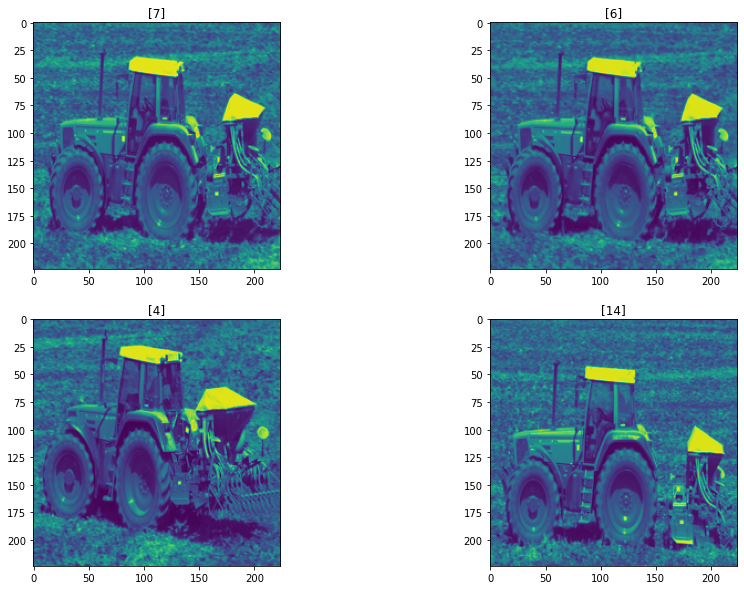

In [43]:
# get some random training images
dataiter = iter(train_loader)
images, images_fft, labels, speeds = dataiter.next()
arthopod_types = {0: 'Coleoptera', 1: 'Diptera', 2: 'Hymenoptera', 3: 'Lepidoptera'}
# Viewing data examples used for training
fig, axis = plt.subplots(2, 2, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, speed = images[i], labels[i], speeds[i] 
        image = image[0] # code 1
        ax.imshow(img_display(image)) # add image
#         ax.set(title = f"{[label.item(), speed.item()]}") # add label
        ax.set(title = f"{[label.item()]}") # add label

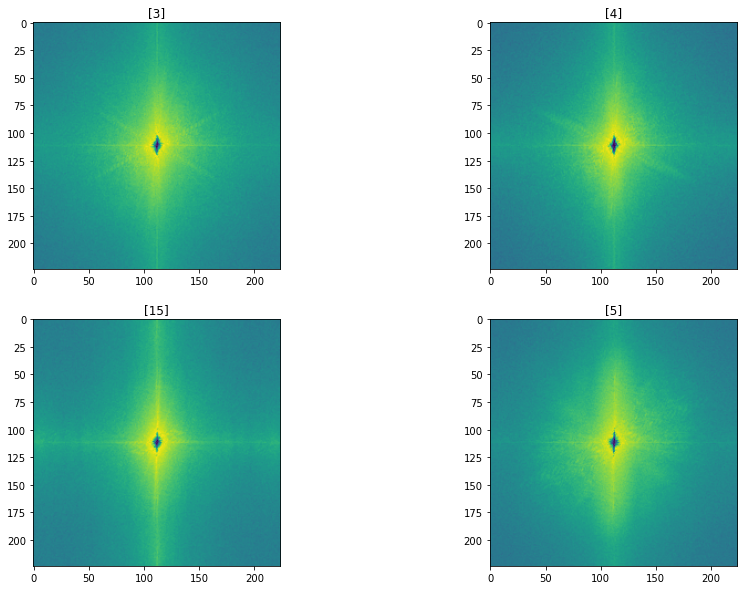

In [44]:
# get some random training images
dataiter = iter(train_loader)
images, images_fft, labels, speeds = dataiter.next()
arthopod_types = {0: 'Coleoptera', 1: 'Diptera', 2: 'Hymenoptera', 3: 'Lepidoptera'}
# Viewing data examples used for training
fig, axis = plt.subplots(2, 2, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, speed = images_fft[i], labels[i], speeds[i] 
        image = image[0] # code 1
        ax.imshow(img_display(image)) # add image
#         ax.set(title = f"{[label.item(), speed.item()]}") # add label
        ax.set(title = f"{[label.item()]}") # add label

In [45]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
#         self.conv1 = nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1) # code 1
        self.conv1 = nn.Conv2d(9,16,kernel_size=3,stride=2,padding=1) # code 3
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,64 )
#         self.fc2 = nn.Linear(512, 256) # regssion
#         self.fc3 = nn.Linear(256, 4) # regssion
#         self.fc2 = nn.Linear(512, 64)#classification
#         self.fc3 = nn.Linear(256, 10)#classification
        
        self.linear = nn.Linear(4, 1)
        self.linear_s = nn.Linear(1, 1)
        self.linear_s1 = nn.Linear(65, 10)
        
        
        
        
        
    def forward(self, img, speed):
        img.float()
        speed.float()
        img = self.batchnorm1(F.relu(self.conv1(img)))
        img = self.batchnorm2(F.relu(self.conv2(img)))
        img = self.dropout(self.batchnorm2(self.pool(img)))
        img = self.batchnorm3(self.pool(F.relu(self.conv3(img))))
        img = self.dropout(self.conv4(img))
        img = img.view(-1, 64*5*5) # Flatten layer
#         img = self.dropout(self.fc1(img))
        img = self.fc1(img)
#         img = self.dropout(self.fc2(img)) # regression 
#         img = self.fc2(img)# classification

#         img = self.linear(self.fc3(img)) # regression 
#         img = self.fc3(img) # classification
        
    
#         img   = self.fc3(img)
        speed = speed.view(speed.size(0), -1)
        speed = self.linear_s(speed)
        speed = speed.view(speed.size(0), -1)
        img   = img.view(speed.size(0), -1)
        x = torch.cat([img, speed], dim=1)
        x = self.linear_s1(x)
        
        
        return x #img
    


In [46]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [47]:
if ~i_m_g:
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()

            vgg16 = models.vgg16(pretrained=True)
    #         vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
            print(vgg16.classifier[6].out_features) # 1000 


            # Freeze training for all layers
            for param in vgg16.features.parameters():
                param.require_grad = False

            # Newly created modules have require_grad=True by default
            num_features = vgg16.classifier[6].in_features
            features = list(vgg16.classifier.children())[:-1] # Remove last layer
            features.extend([nn.Linear(num_features, 10)]) # Add our layer with 4 outputs
            vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
            self.model_ft1 = vgg16
            self.model_ft2 = vgg16
    #         self.model_ft3 = vgg16



            self.linear = nn.Linear(4, 1)
            self.linear_s = nn.Linear(1, 1)
            self.linear_s1 = nn.Linear(23, 1)





        def forward(self, img, speed):
            img.float()
            speed.float()


            img1 = self.model_ft1(img[ :, :3, :, :])
            img2 = self.model_ft2(img[ :, 3:6, :, :])
    #         img3 = self.model_ft3(img[ :, 6:9, :, :])


            speed = speed.view(speed.size(0), -1)
    #         speed = self.linear_s(speed)
            speed = speed.view(speed.size(0), -1)
            img1   = img1.view(speed.size(0), -1)
            img2   = img2.view(speed.size(0), -1)
    #         img3   = img3.view(speed.size(0), -1)
    #         x = torch.cat([img1, img2, img3, speed], dim=1)
            x = torch.cat([img1, img2, speed], dim=1)
            x = self.linear_s1(x)


            return x
    
if i_m_g:
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()

            vgg16 = models.vgg16(pretrained=True)
    #         vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
            print(vgg16.classifier[6].out_features) # 1000 


            # Freeze training for all layers
            for param in vgg16.features.parameters():
                param.require_grad = False

            # Newly created modules have require_grad=True by default
            num_features = vgg16.classifier[6].in_features
            features = list(vgg16.classifier.children())[:-1] # Remove last layer
            features.extend([nn.Linear(num_features, 1)]) # Add our layer with 4 outputs
            vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
            
            self.model_ft1 = vgg16

            vgg16_1 = models.vgg16(pretrained=True)
    #         vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
            print(vgg16_1.classifier[6].out_features) # 1000 

            for param in vgg16_1.features.parameters():
                param.require_grad = False

            # Newly created modules have require_grad=True by default
            num_features = vgg16_1.classifier[6].in_features
            features = list(vgg16_1.classifier.children())[:-1] # Remove last layer
            features.extend([nn.Linear(num_features, 20)]) # Add our layer with 4 outputs
            vgg16_1.classifier = nn.Sequential(*features) # Replace the model classifier
            self.model_ft2 = vgg16_1
            
    #         self.model_ft = models.inception_v3(pretrained=True)
    #         for param in self.model_ft.parameters():
    #             param.requires_grad = False

    #         # Parameters of newly constructed modules have requires_grad=True by default
    #         # Handle the auxilary net
    #         self.num_ftrs = self.model_ft.AuxLogits.fc.in_features
    #         self.model_ft.AuxLogits.fc = nn.Linear(self.num_ftrs, 2)
    #         # Handle the primary net
    #         num_ftrs = self.model_ft.fc.in_features
    #         self.model_ft.fc = nn.Linear(self.num_ftrs, 4)


            self.linear = nn.Linear(4, 1)
            self.linear_s = nn.Linear(1, 1)
            if regression : 
                self.linear_s1 = nn.Linear(24, 1)
            else:
                self.linear_s1 = nn.Linear(24, 20)





        def forward(self, img_original, img_original_fft, speed):
            img_original.float()
            speed.float()

            speed = speed.view(speed.size(0), -1)
        
            model1_outs_10 = self.model_ft1(img_original)
            model1_outs_10   = model1_outs_10.view(speed.size(0), -1)
            
            model2_outs_10 = self.model_ft2(img_original_fft)
            model2_outs_10   = model2_outs_10.view(speed.size(0), -1)
            
    #         speed = self.linear_s(speed)
            
            
            x = torch.cat([model1_outs_10, speed], dim=1)
            x = x.view(speed.size(0), -1)
            x = torch.cat([x, model2_outs_10], dim=1)
            x = self.linear_s1(x)


            return x

# model = Net().to(device)  # On GPU
# if regression:
#     criterion = nn.MSELoss()# regression
# else :
#     criterion = nn.CrossEntropyLoss()# classification

# print(model)

In [48]:
# for epoch in tqdm_notebook(range(1, 20+1)):
#     print(0.0001 + 1/((100+epoch**2)*10))

In [49]:
#  + 1/((100+epoch**2)*10)

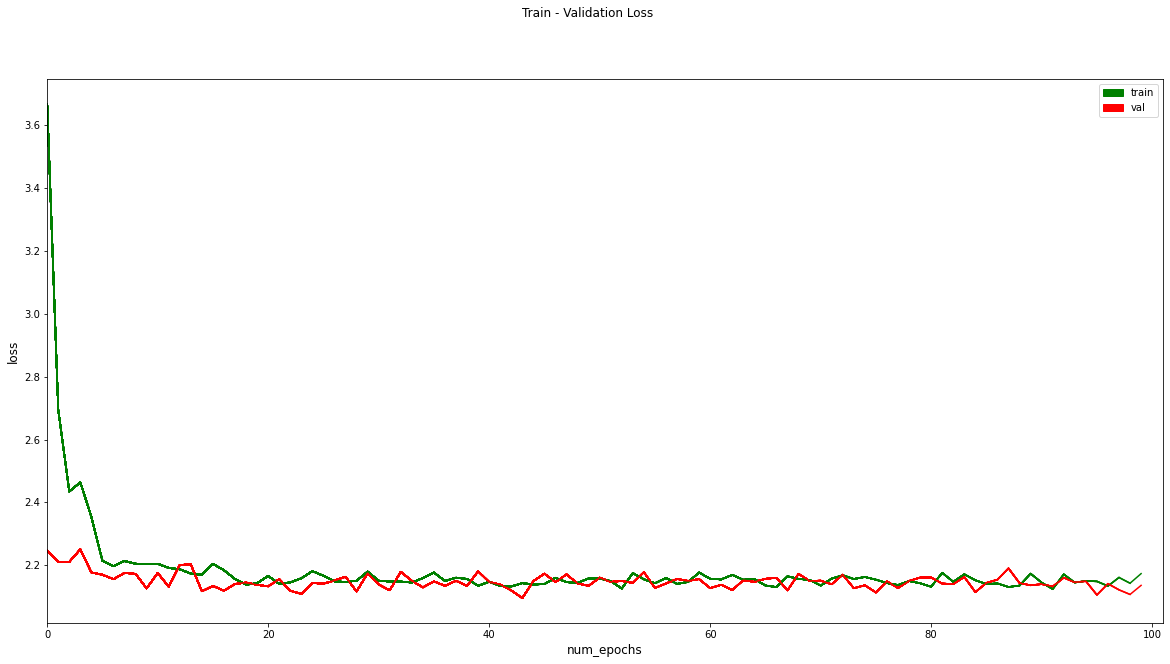

reducing lr



In [50]:
n_epochs = 100
model = Net().to(device)  # On GPU
if regression:
    criterion = nn.MSELoss()# regression
else :
    criterion = nn.CrossEntropyLoss()# classification


print_every = 1
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
prediction_dataset = {}

val_target = []
val_pred = []


total_step = len(train_loader)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1) 
fig.suptitle("Train - Validation Loss")
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc=2, prop={'size': 60})
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='green', label='train')
green_patch = mpatches.Patch(color='red', label='val')
plt.legend(handles=[red_patch, green_patch])
ax.set_xlim(0, n_epochs+1)

lr = 0.001
f = 2/5
r =  n_epochs

loss_reg = [0]*5
count = 0

for i in range(100):
    if np.std(loss_reg) <= np.mean(loss_reg) / 2:
        loss_reg.append(i)
        loss_reg = loss_reg[1:]
        print(loss_reg)


for epoch in tqdm_notebook(range(1, n_epochs+1)):
    try:
        print('lr : ', lr)
        print(loss_reg)
        print(prediction_dataset[epoch-1])
    except:
        print("")
    gc.collect()
    if cycle : 
        LR = lr/(f+1) + lr/(f+1)*f*np.cos(epoch/r*np.pi)
    else:
        LR = lr
#     optimizer = optim.Adam(model.parameters(), lr=LR, )
    optimizer = optim.AdamW(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
#     optimizer = optim.AdamW(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08,amsgrad=False)
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_,  data_fft_, target_, speeds_) in tqdm_notebook(enumerate(train_loader)):
        data_ = data_.float()
        data_fft_ = data_fft_.float()
        if regression:
            target_ = target_.float() # regression
        speeds_ = speeds_.float()
        data_, data_fft_, target_ , speeds_ = data_.to(device),  data_fft_.to(device), target_.to(device), speeds_.to(device) # on GPU
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        
        outputs = model(data_, data_fft_, speeds_)
#         print(outputs.shape)
        
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, data_t_fft, target_t, speeds_t in (validation_loader):
            data_t.float()
            data_t_fft.float()
            if regression:
                target_t = target_t.float() # regression
            speeds_t = speeds_t.float()
            data_t, data_t_fft, target_t, speeds_t = data_t.to(device), data_t_fft.to(device), target_t.to(device), speeds_t.to(device) # on GPU
            outputs_t = model(data_t, data_t_fft, speeds_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
            
            
            for tar in target_t:
                val_target.append(tar*10)
            if regression:
                predd = outputs_t
            else:
                predd = outputs_t.argmax(axis = 1)
            for pre in predd:
                val_pred.append(pre*10)
            
        prediction_dataset[epoch] = pd.DataFrame({"target" : val_target, "preds" : val_pred})
        
        val_target = []
        val_pred = []
        
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()



    ax.plot( train_loss, label='train', color='green')
    ax.plot( val_loss, label='val', color='red')
    clear_output(wait = True)
    display(fig)
    
    last_reg = np.mean(loss_reg)
    loss_reg.append(val_loss[-1])
    loss_reg = loss_reg[1:]
    count += 1
    
    if (np.std(loss_reg) <= np.mean(loss_reg) / 50 and count >= 5) or (np.mean(loss_reg) > last_reg + last_reg/5 and count >= 5):
        print('reducing lr')
        if lr > 0.0000001 and epoch > 15:
            count = 0
            lr /= 10
        
    
    
    plt.pause(0.5)




In [51]:
loss_reg

[2.106400430202484,
 2.1418908834457397,
 2.122510333855947,
 2.107879181702932,
 2.1366849342981973]

In [52]:
np.std(loss_reg)

0.014481303697432227

In [53]:
np.mean(loss_reg) /1000

0.00212307315270106

In [54]:
# pred = pd.DataFrame(prediction_dataset)
# pred.to_csv("pred.csv", index=False)

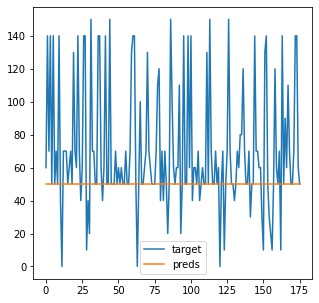

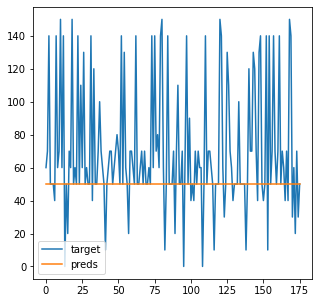

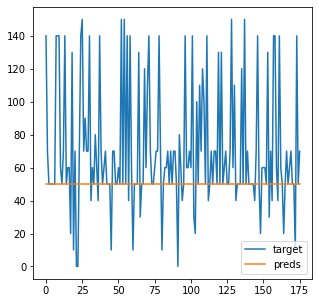

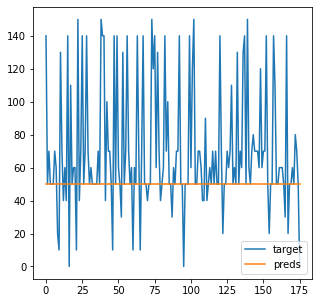

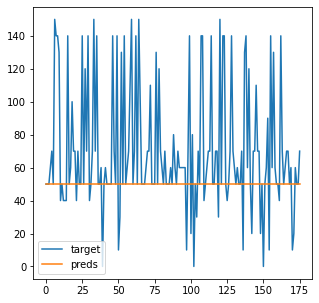

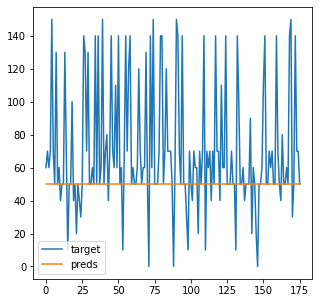

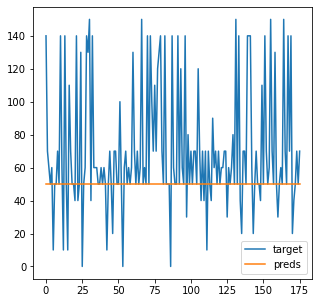

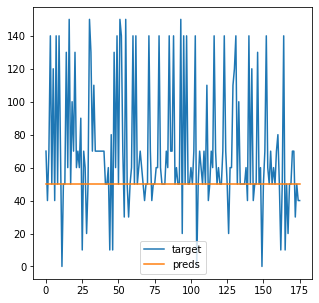

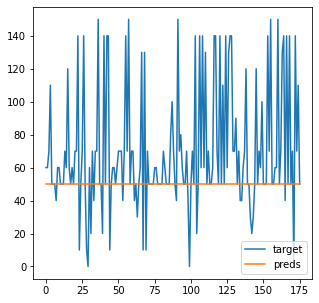

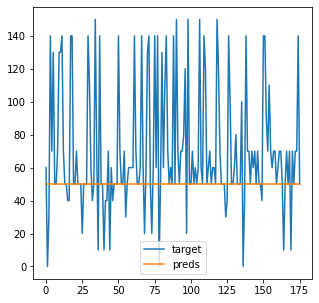

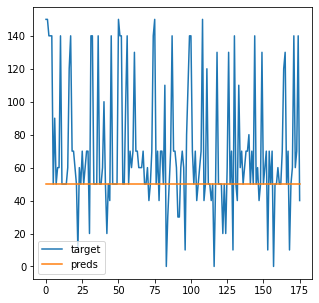

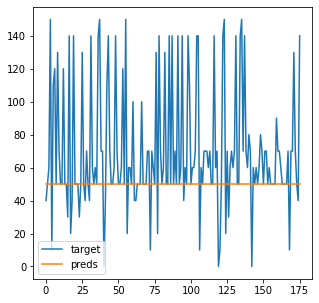

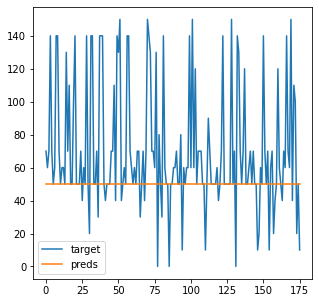

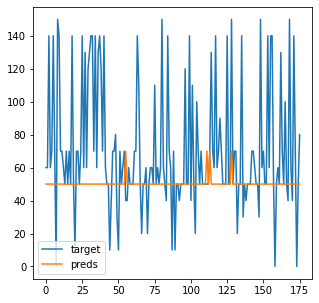

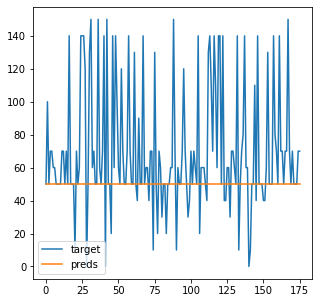

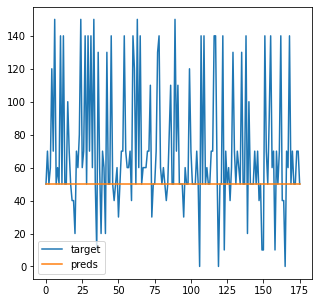

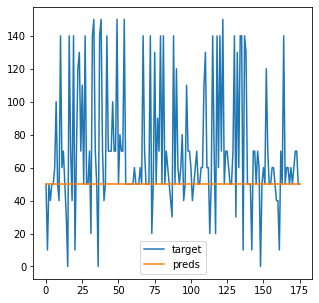

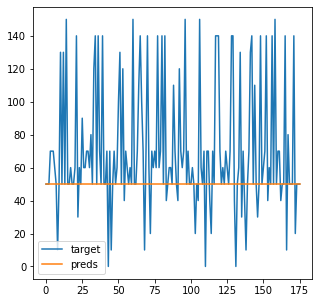

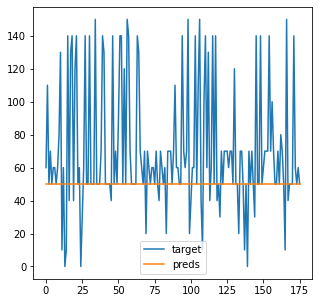

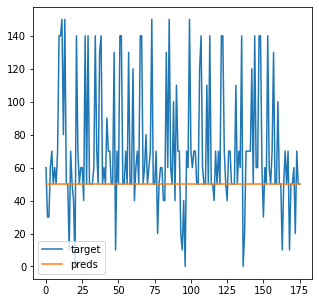

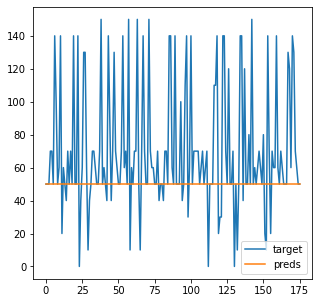

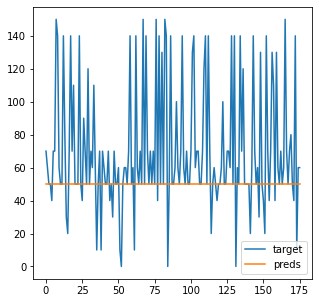

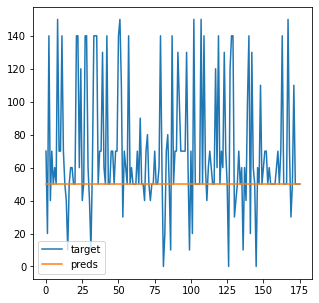

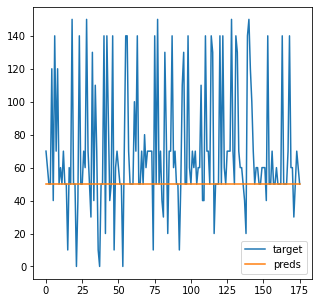

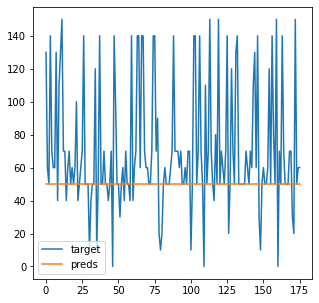

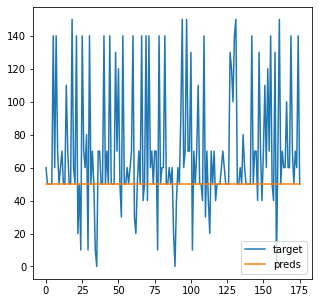

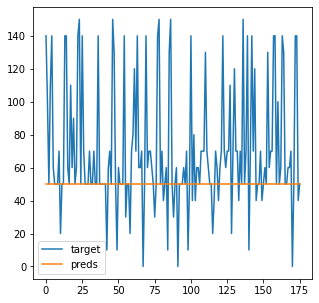

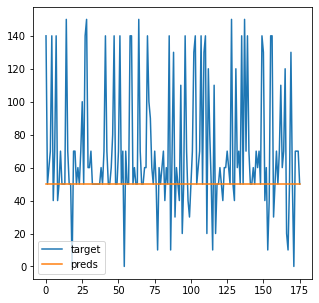

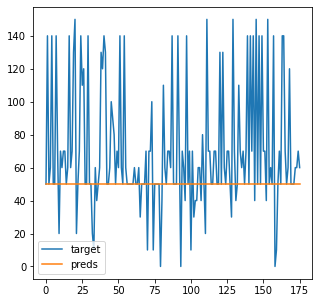

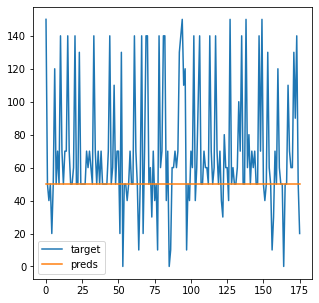

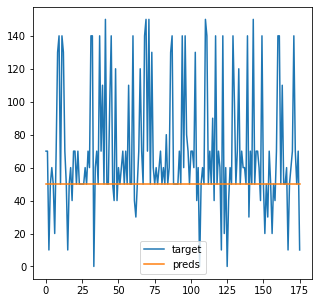

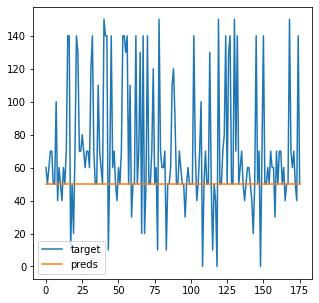

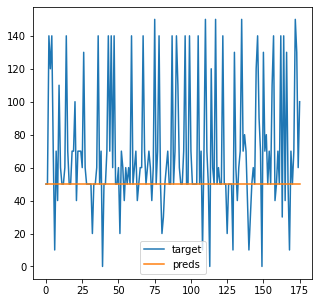

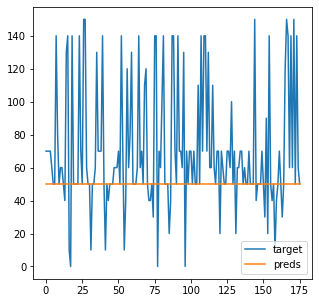

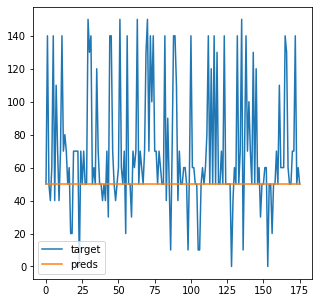

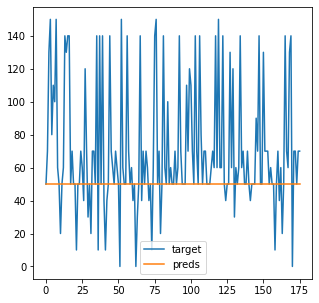

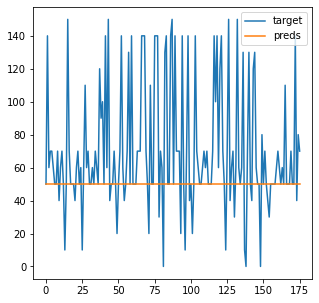

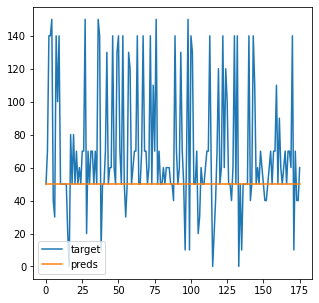

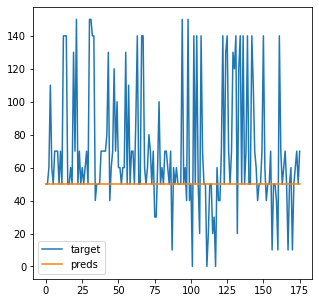

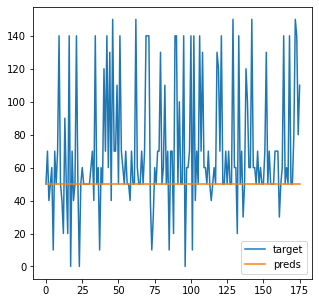

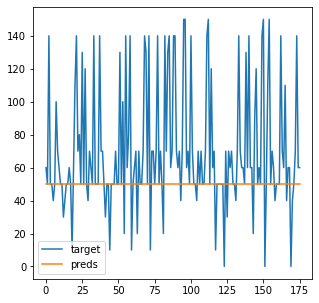

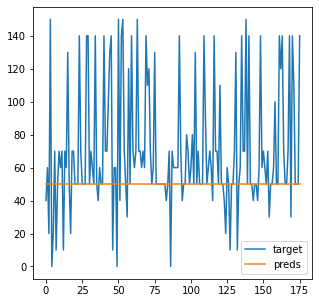

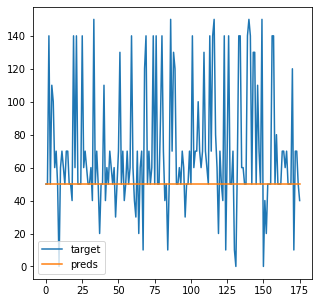

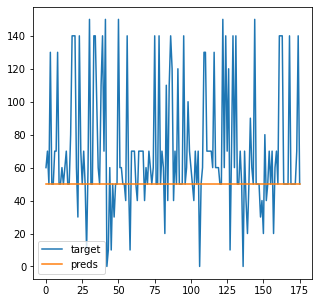

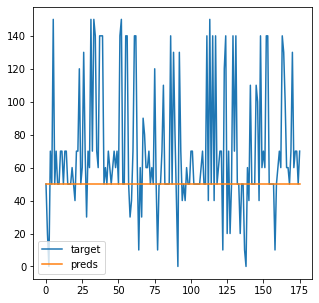

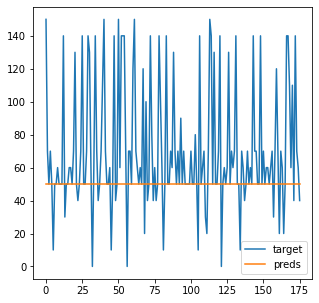

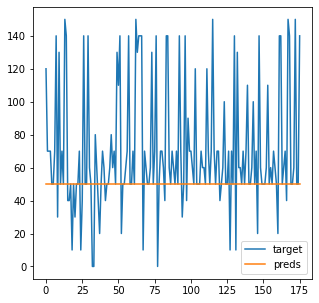

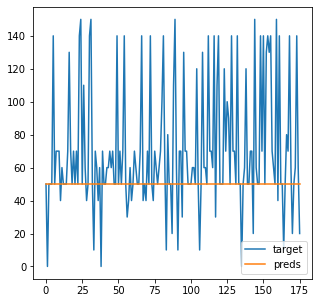

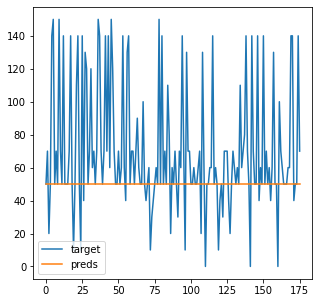

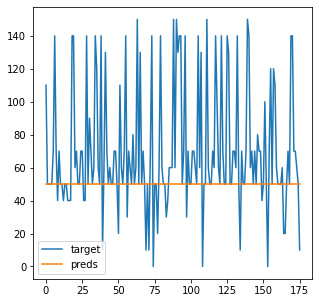

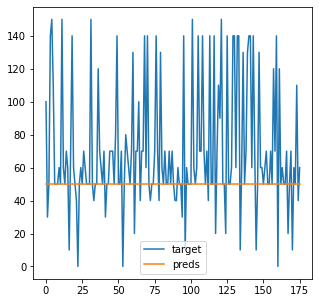

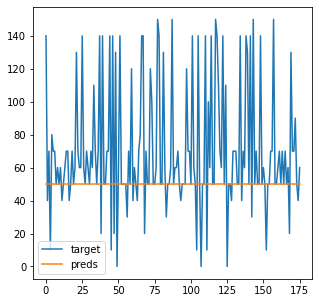

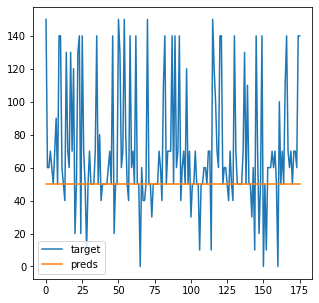

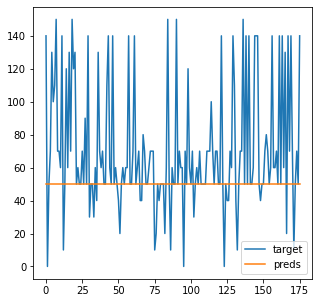

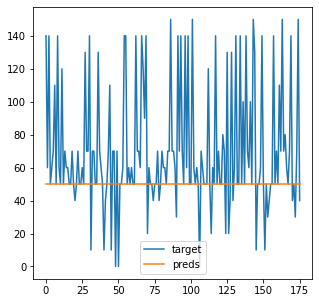

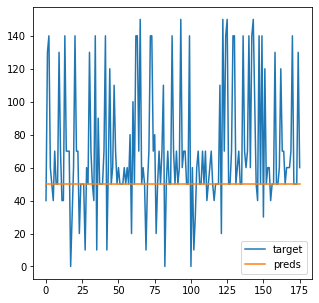

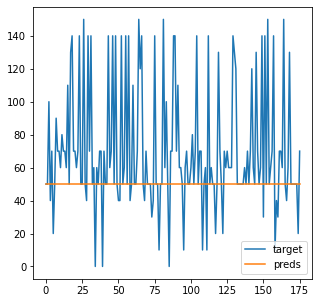

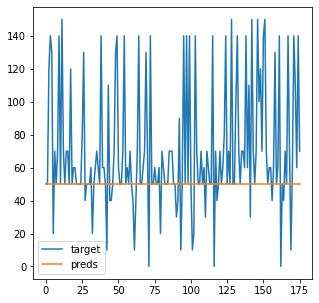

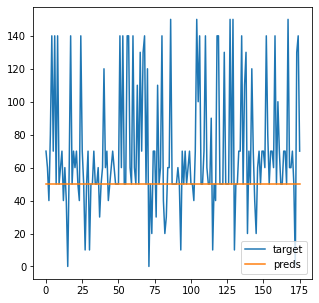

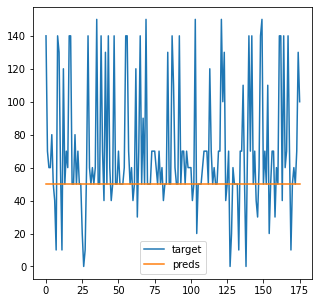

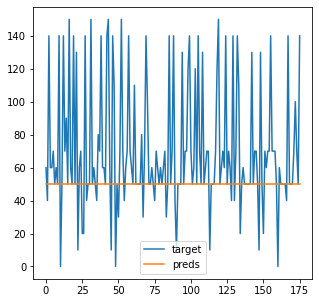

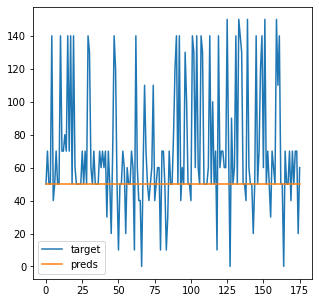

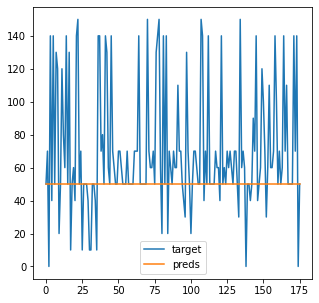

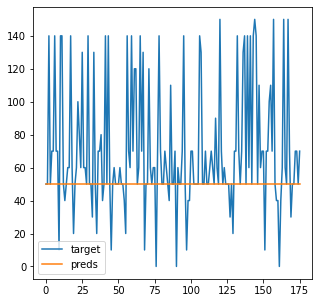

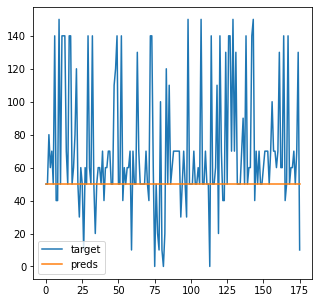

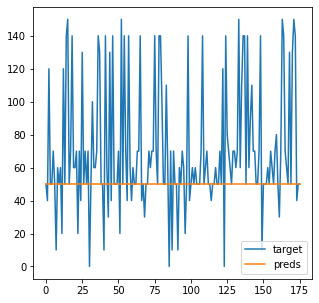

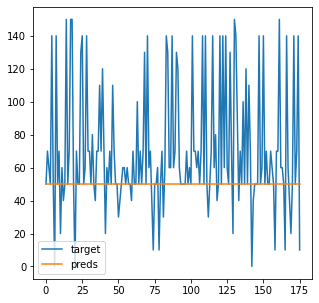

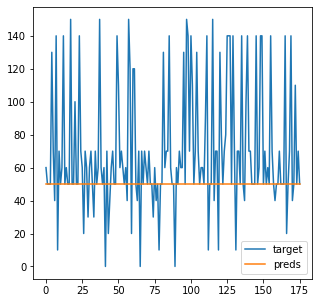

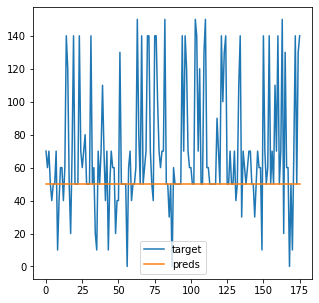

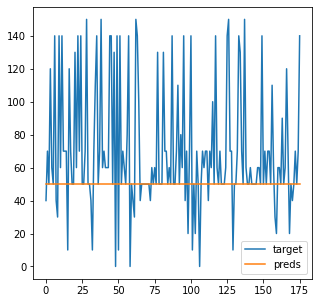

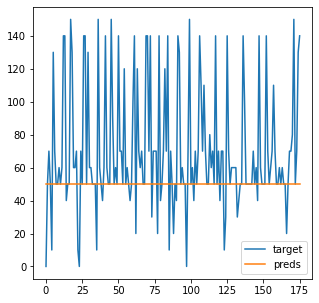

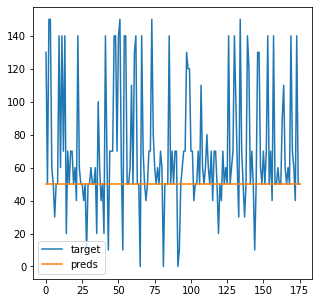

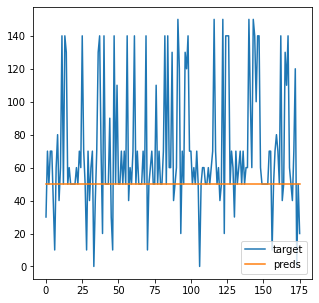

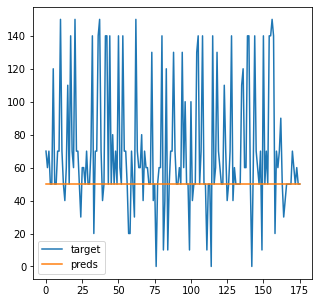

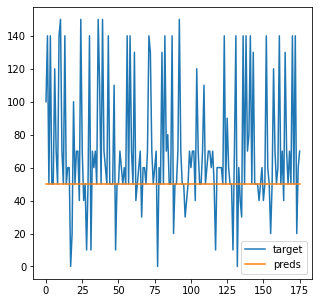

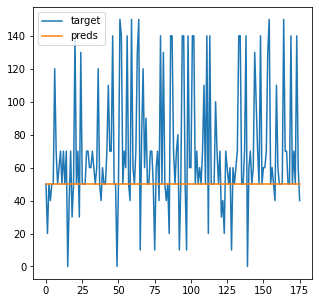

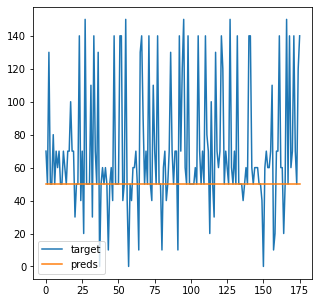

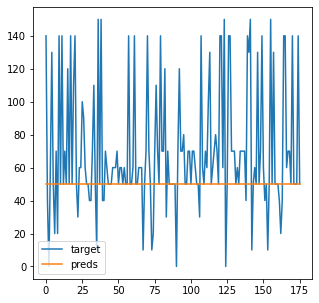

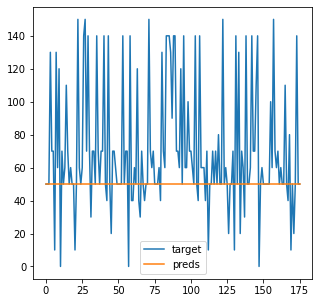

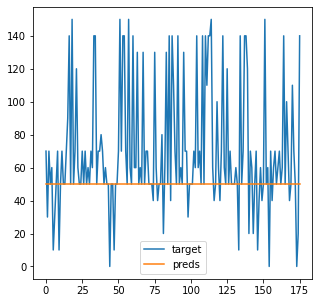

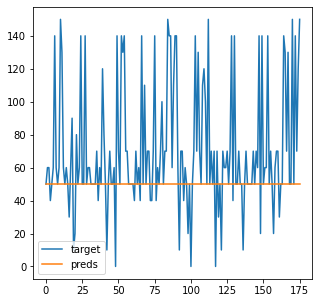

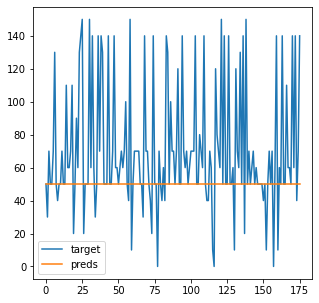

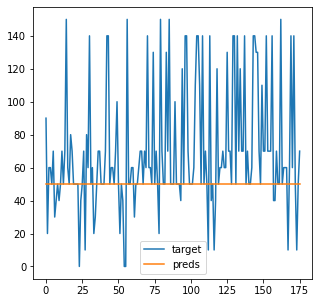

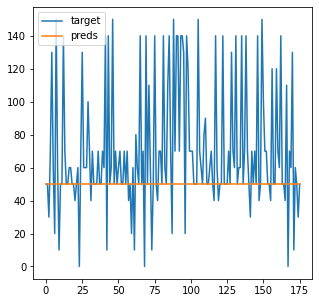

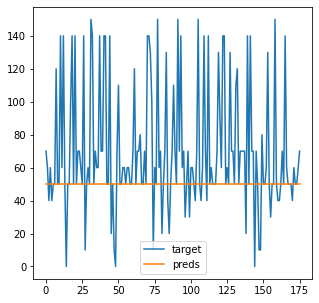

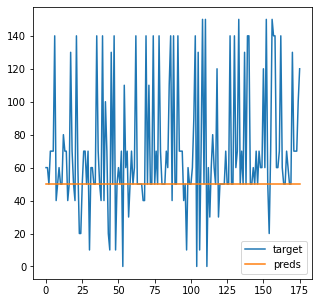

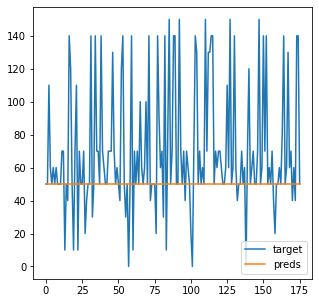

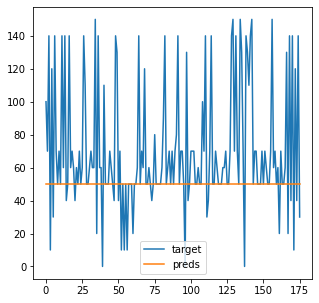

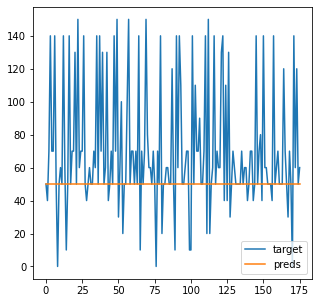

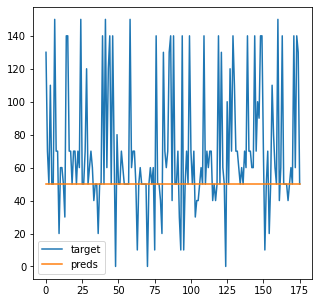

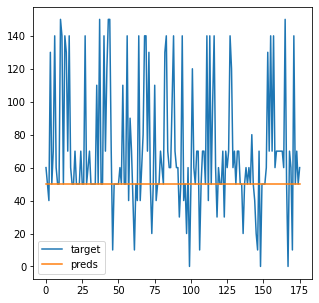

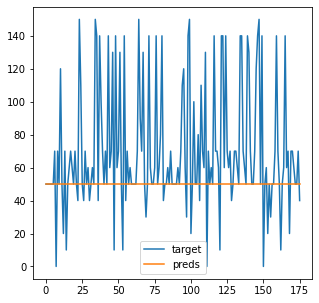

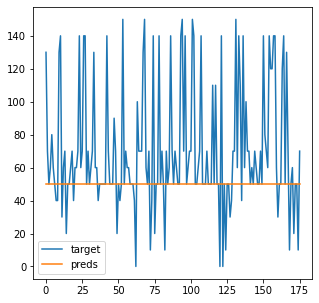

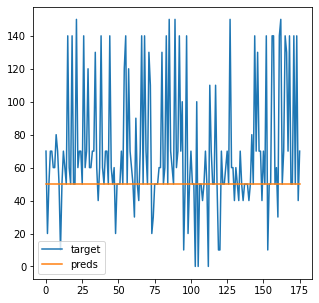

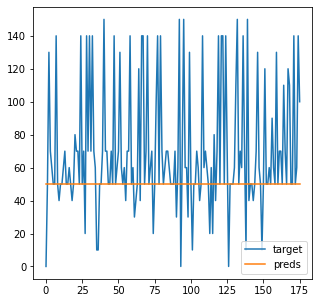

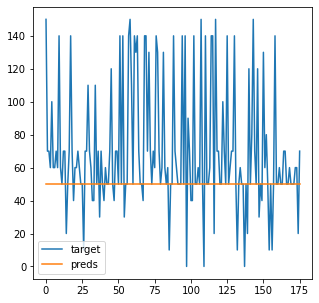

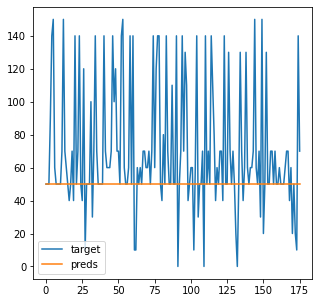

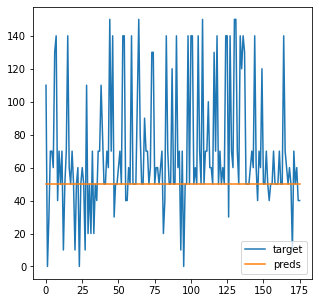

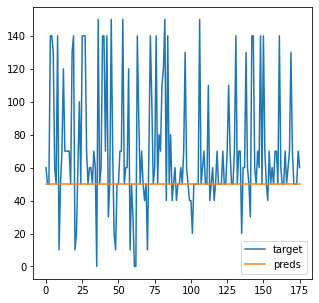

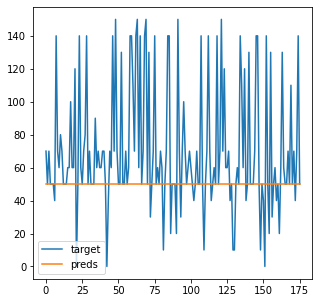

In [55]:
for i in range(1, len(prediction_dataset)+1):
    tar = prediction_dataset[i]['target'].apply(lambda x : x.data.cpu().numpy())
    pre = prediction_dataset[i]['preds'].apply(lambda x : x.data.cpu().numpy())
    fig = plt.figure(figsize=(5,5))
    plt.plot( tar, label='target')
    plt.plot( pre, label='preds')
    plt.legend(loc='best')

In [56]:
import pickle 
  
dictionary = {'geek': 1, 'supergeek': True, 4: 'geeky'} 
  
try: 
    geeky_file = open('geekyfile', 'wb') 
    pickle.dump(prediction_dataset, geeky_file) 
    geeky_file.close() 

except: 
    print("Something went wrong")
    
with open('geekyfile', 'rb') as f:
    x = pickle.load(f)


In [57]:
FileLinks('.')

./
  model_classification_tutorial.pt
  geekyfile
  __notebook__.ipynb
./Y/
  tr_qp38_qp26_3y16fft.png
  tr_qp44_qp26_3y112.png
  tr_qp38_qp26_2y204fft.png
  tr_qp44_qp26_3y90.png
  tr_qp38_qp26_3y200.png
  tr_qp38_qp26_3y64fft.png
  tr_qp38_qp26_2y105.png
  tr_qp38_qp26_3y215.png
  tr_qp38_qp26_2y64fft.png
  tr_qp44_qp26_3y153.png
  tr_qp44_qp26_3y162fft.png
  tr_qp38_qp26_5y176fft.png
  tr_qp38_qp26_2y32fft.png
  tr_qp38_qp26_2y110.png
  tr_qp38_qp26_5y78.png
  tr_qp38_qp26_3y43fft.png
  tr_qp38_qp26_2y181fft.png
  tr_qp38_qp26_2y126fft.png
  tr_qp38_qp26_2y137.png
  tr_qp44_qp26_3y164fft.png
  tr_qp38_qp26_5y60fft.png
  tr_qp38_qp26_5y14fft.png
  tr_qp44_qp26_3y181fft.png
  tr_qp44_qp26_3y183fft.png
  tr_qp38_qp26_5y217.png
  tr_qp38_qp26_3y117fft.png
  tr_qp38_qp26_5y218.png
  tr_qp38_qp26_3y170.png
  tr_qp38_qp26_2y25.png
  tr_qp44_qp26_3y47.png
  tr_qp44_qp26_3y152fft.png
  tr_qp38_qp26_5y98.png
  tr_qp38_qp26_5y203fft.png
  tr_qp38_qp26_5y105fft.png
  tr_qp44_qp26_3y28.png
  tr_qp38_qp26_5y61fft.png
  tr_qp38_qp26_2y194fft.png
  tr_qp38_qp26_2y118.png
  tr_qp38_qp26_2y27.png
  tr_qp38_qp26_5y80fft.png
  tr_qp38_qp26_5y168.png
  tr_qp38_qp26_5y181fft.png
  tr_qp38_qp26_5y187.png
  tr_qp38_qp26_2y72.png
  tr_qp38_qp26_5y45.png
  tr_qp44_qp26_3y10.png
  tr_qp38_qp26_2y43.png
  tr_qp38_qp26_5y179.png
  tr_qp44_qp26_3y56fft.png
  tr_qp38_qp26_3y165fft.png
  tr_qp38_qp26_2y81fft.png
  tr_qp44_qp26_3y222.png
  tr_qp38_qp26_5y150.png
  tr_qp38_qp26_2y47.png
  tr_qp38_qp26_5y121.png
  tr_qp38_qp26_5y5fft.png
  tr_qp38_qp26_5y50fft.png
  tr_qp38_qp26_2y163fft.png
  tr_qp38_qp26_5y32fft.png
  tr_qp38_qp26_5y41.png
  tr_qp38_qp26_2y180fft.png
  tr_qp38_qp26_2y12fft.png
  tr_qp38_qp26_2y145fft.png
  tr_qp44_qp26_3y66.png
  tr_qp38_qp26_3y4fft.png
  tr_qp38_qp26_5y199fft.png
  tr_qp38_qp26_3y10.png
  tr_qp44_qp26_3y126.png
  tr_qp38_qp26_5y52.png
  tr_qp38_qp26_5y196.png
  tr_qp38_qp26_3y11.png
  tr_qp38_qp26_3y27.png
  tr_qp38_qp26_5y169fft.png
  tr_qp44_qp26_3y133fft.png
  tr_qp38_qp26_2y24fft.png
  tr_qp38_qp26_2y156.png
  tr_qp38_qp26_2y117.png
  tr_qp38_qp26_3y121fft.png
  tr_qp44_qp26_3y95fft.png
  tr_qp38_qp26_3y165.png
  tr_qp38_qp26_3y36.png
  tr_qp38_qp26_3y83fft.png
  tr_qp38_qp26_3y159.png
  tr_qp38_qp26_3y220fft.png
  tr_qp38_qp26_5y125fft.png
  tr_qp38_qp26_5y119fft.png
  tr_qp44_qp26_3y98.png
  tr_qp38_qp26_2y4.png
  tr_qp38_qp26_3y184.png
  tr_qp38_qp26_3y125fft.png
  tr_qp38_qp26_5y144.png
  tr_qp38_qp26_3y158fft.png
  tr_qp44_qp26_3y4.png
  tr_qp44_qp26_3y76.png
  tr_qp38_qp26_3y66.png
  tr_qp38_qp26_5y4fft.png
  tr_qp38_qp26_2y21fft.png
  tr_qp44_qp26_3y169fft.png
  tr_qp38_qp26_2y66.png
  tr_qp38_qp26_2y146.png
  tr_qp38_qp26_5y92.png
  tr_qp38_qp26_5y43fft.png
  tr_qp38_qp26_2y39fft.png
  tr_qp38_qp26_5y50.png
  tr_qp38_qp26_2y92fft.png
  tr_qp38_qp26_3y87fft.png
  tr_qp38_qp26_5y222.png
  tr_qp38_qp26_2y191fft.png
  tr_qp38_qp26_3y125.png
  tr_qp38_qp26_2y71fft.png
  tr_qp38_qp26_5y82.png
  tr_qp44_qp26_3y64fft.png
  tr_qp38_qp26_3y116.png
  tr_qp38_qp26_3y152.png
  tr_qp44_qp26_3y164.png
  tr_qp38_qp26_2y135.png
  tr_qp38_qp26_5y79.png
  tr_qp38_qp26_2y109fft.png
  tr_qp38_qp26_2y200.png
  tr_qp38_qp26_2y60.png
  tr_qp44_qp26_3y63.png
  tr_qp38_qp26_2y96.png
  tr_qp38_qp26_2y210fft.png
  tr_qp44_qp26_3y27fft.png
  tr_qp38_qp26_2y210.png
  tr_qp38_qp26_2y158.png
  tr_qp38_qp26_3y81fft.png
  tr_qp44_qp26_3y161.png
  tr_qp44_qp26_3y49fft.png
  tr_qp38_qp26_5y167.png
  tr_qp44_qp26_3y22fft.png
  tr_qp44_qp26_3y70fft.png
  tr_qp38_qp26_5y110fft.png
  tr_qp38_qp26_3y172.png
  tr_qp44_qp26_3y96fft.png
  tr_qp38_qp26_5y115.png
  tr_qp38_qp26_3y194.png
  tr_qp44_qp26_3y200.png
  tr_qp44_qp26_3y64.png
  tr_qp38_qp26_3y223fft.png
  tr_qp38_qp26_3y107fft.png
  tr_qp44_qp26_3y208fft.png
  tr_qp38_qp26_5y138fft.png
  tr_qp38_qp26_5y20.png
  tr_qp44_qp26_3y172fft.png
  tr_qp38_qp26_5y112.png
  tr_qp44_qp26_3y179fft.png
  tr_qp38_qp26_2y171.png
  tr_qp38_qp26_5y72.png
  tr_qp44_qp26_3y195fft.png
  tr_qp38_qp26_5y200.png
  tr_q

In [58]:
prediction_dataset[1]

target                        preds
0     tensor(60, device='cuda:0')  tensor(50, device='cuda:0')
1    tensor(140, device='cuda:0')  tensor(50, device='cuda:0')
2     tensor(70, device='cuda:0')  tensor(50, device='cuda:0')
3    tensor(140, device='cuda:0')  tensor(50, device='cuda:0')
4     tensor(50, device='cuda:0')  tensor(50, device='cuda:0')
..                            ...                          ...
171   tensor(70, device='cuda:0')  tensor(50, device='cuda:0')
172  tensor(140, device='cuda:0')  tensor(50, device='cuda:0')
173  tensor(140, device='cuda:0')  tensor(50, device='cuda:0')
174   tensor(60, device='cuda:0')  tensor(50, device='cuda:0')
175   tensor(50, device='cuda:0')  tensor(50, device='cuda:0')

[176 rows x 2 columns]

In [59]:
outputs.shape

torch.Size([8, 20])

In [60]:
train_loss

[3.66634724451148,
 2.6947276384934136,
 2.434957639030788,
 2.4639297360959262,
 2.354125199110612,
 2.2146785311076953,
 2.1979185083638066,
 2.2142164759013965,
 2.2054757294447525,
 2.20438886207083,
 2.205308566922727,
 2.192139190176259,
 2.187769159026768,
 2.174154229786085,
 2.1699995113455732,
 2.2048449568126514,
 2.184737635695416,
 2.156793335209722,
 2.1388926350552104,
 2.1436100628065025,
 2.1666158126748125,
 2.1414243708486143,
 2.14613587959953,
 2.1593144821084063,
 2.1818872690200806,
 2.1671902355940444,
 2.149391656336577,
 2.1475284099578857,
 2.1513894848201587,
 2.180410017137942,
 2.1515618770018867,
 2.148938407068667,
 2.1486380566721377,
 2.1458979637726494,
 2.159765502680903,
 2.1772407396979956,
 2.1507543688235073,
 2.1610087570936782,
 2.1571195125579834,
 2.1354482588560684,
 2.148040216902028,
 2.1350112116855122,
 2.1331863506980566,
 2.1437538240266885,
 2.139669558276301,
 2.1407896902250205,
 2.1608027375262715,
 2.1469883659611577,
 2.144706415

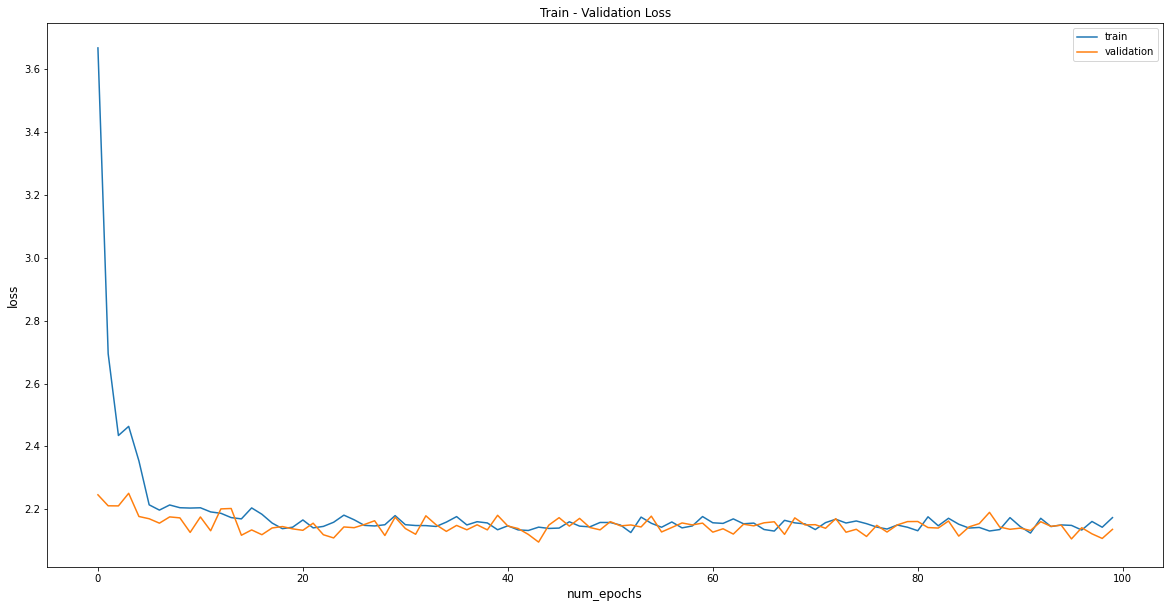

In [61]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

In [62]:
speeds_t

tensor([[0.3624, 0.3624, 0.3624],
        [0.3876, 0.3876, 0.3876],
        [0.2087, 0.2087, 0.2087],
        [0.3506, 0.3506, 0.3506],
        [0.3275, 0.3275, 0.3275],
        [0.3613, 0.3613, 0.3613],
        [0.3624, 0.3624, 0.3624],
        [0.2651, 0.2651, 0.2651],
        [0.4319, 0.4319, 0.4319],
        [0.2079, 0.2079, 0.2079],
        [0.3549, 0.3549, 0.3549],
        [0.2118, 0.2118, 0.2118],
        [0.2294, 0.2294, 0.2294],
        [0.3256, 0.3256, 0.3256],
        [0.3947, 0.3947, 0.3947],
        [0.2079, 0.2079, 0.2079]], device='cuda:0')

In [63]:
target_t

tensor([ 5,  2,  6, 13,  6,  5,  5,  7,  5, 11,  5,  7,  4,  7, 14,  5],
       device='cuda:0')

In [64]:
if regression:
    print(outputs_t)
else:
    print(outputs_t.argmax(axis = 1))

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0')


In [65]:
accuracy(outputs_t, target_t) #/len(target_t)

6

In [66]:
pre = np.array(prediction_dataset[i]['preds'].apply(lambda x : x.data.cpu().numpy()))
tar = np.array(prediction_dataset[i]['target'].apply(lambda x : x.data.cpu().numpy()))
pre

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50])

In [67]:
tar

array([ 70,  50,  70,  50,  50,  50,  40, 140,  70,  60,  80,  70,  50,
        50,  50,  60,  60, 100,  60,  60, 120,   0,  50, 140,  60,  50,
        70,  80, 140,  50,  70,  50,  50,  50,  90,  60,  70,  60,  60,
        70,  70,  50,   0,  40,  70,  60, 140,  70, 150,  70,  50,  50,
       130,  50,  50,  70,  50,  60, 140, 140, 110,  70, 140, 150,  60,
       140,  50,  70, 140, 150,  50, 130,  30,  50,  70, 140,  50,  60,
        50,  70,  60,  10,  50,  70, 140, 140,  20,  50,  50,  50,  20,
       150,  70,  30,  70, 100,  70,  50,  60,  70,  60,  50,  40,  50,
        70,  50,  50, 140,  50,  10,  50,  70, 140,  70,  40,  50,  60,
        50, 140,  50,  70, 150,  70, 120,  60,  60,  70,  40,  50,  10,
        10,  50,  60,  50, 140, 110,  60, 120,  40,  50, 130,  50,  50,
        50,  70, 140, 140,  50,  10,  50,  40,   0, 140,  50,  20, 130,
        30,  50,  60,  40,  50,  20,  60, 130,  60,  50,  50,  70,  50,
       110,  50,  70,  40,  70, 140,  50])

In [68]:

accuracy(pre, tar) /len(tar)

TypeError: max() received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (Tensor input)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)


In [69]:
train_loss

[3.66634724451148,
 2.6947276384934136,
 2.434957639030788,
 2.4639297360959262,
 2.354125199110612,
 2.2146785311076953,
 2.1979185083638066,
 2.2142164759013965,
 2.2054757294447525,
 2.20438886207083,
 2.205308566922727,
 2.192139190176259,
 2.187769159026768,
 2.174154229786085,
 2.1699995113455732,
 2.2048449568126514,
 2.184737635695416,
 2.156793335209722,
 2.1388926350552104,
 2.1436100628065025,
 2.1666158126748125,
 2.1414243708486143,
 2.14613587959953,
 2.1593144821084063,
 2.1818872690200806,
 2.1671902355940444,
 2.149391656336577,
 2.1475284099578857,
 2.1513894848201587,
 2.180410017137942,
 2.1515618770018867,
 2.148938407068667,
 2.1486380566721377,
 2.1458979637726494,
 2.159765502680903,
 2.1772407396979956,
 2.1507543688235073,
 2.1610087570936782,
 2.1571195125579834,
 2.1354482588560684,
 2.148040216902028,
 2.1350112116855122,
 2.1331863506980566,
 2.1437538240266885,
 2.139669558276301,
 2.1407896902250205,
 2.1608027375262715,
 2.1469883659611577,
 2.144706415

In [70]:
val_loss

[2.2465208967526755,
 2.2115670839945474,
 2.2112543185551963,
 2.2513030767440796,
 2.1776143312454224,
 2.170437137285868,
 2.1563929319381714,
 2.17630664507548,
 2.173214395840963,
 2.1270567377408347,
 2.176114638646444,
 2.1322396993637085,
 2.201752702395121,
 2.203036983807882,
 2.118027647336324,
 2.134936253229777,
 2.1197478572527566,
 2.141152262687683,
 2.1456170678138733,
 2.138307809829712,
 2.1337323983510337,
 2.156326631704966,
 2.119629999001821,
 2.1094841758410134,
 2.144377907117208,
 2.1420137087504068,
 2.152139147122701,
 2.1640630960464478,
 2.1172463297843933,
 2.1752754847208657,
 2.139352262020111,
 2.1211306055386863,
 2.1798189878463745,
 2.1511968970298767,
 2.130315105120341,
 2.1492505272229514,
 2.1353297233581543,
 2.1511807441711426,
 2.1350910862286887,
 2.181414087613424,
 2.1472915609677634,
 2.13948655128479,
 2.120603640874227,
 2.096278488636017,
 2.150300939877828,
 2.173850496610006,
 2.1469971338907876,
 2.171619196732839,
 2.14266447226206

In [71]:
# FileLinks('.')

**what is cross entropy loss**
**what is YUV**
**what is FFT for an image**
